In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.tabular.all import *
from fastai.collab import *

In [26]:
import os
os.environ['KAGGLE_USERNAME'] = "demiminjarez"
os.environ['KAGGLE_KEY'] = "71118f339b2ffe1143d9fec6ed72ebf7"


In [27]:
# Download the TMDB Movie Metadata dataset
!kaggle datasets download -d tmdb/tmdb-movie-metadata

# Unzip the downloaded file
!unzip -o tmdb-movie-metadata.zip -d tmdbdata


Dataset URL: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
License(s): other
tmdb-movie-metadata.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  tmdb-movie-metadata.zip
  inflating: tmdbdata/tmdb_5000_credits.csv  
  inflating: tmdbdata/tmdb_5000_movies.csv  


In [28]:
# Load the dataset
csv_path = 'tmdbdata/tmdb_5000_movies.csv'
df_movies = pd.read_csv(csv_path)

In [29]:
df_movies.head(0)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count


In [30]:
df_movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [31]:
missing_values = df_movies.isnull().sum()
missing_values

,0
budget,0
genres,0
homepage,3091
id,0
keywords,0
original_language,0
original_title,0
overview,3
popularity,0
production_companies,0


In [32]:

# Drop rows with missing values
df_movies = df_movies.dropna()

In [33]:
# Data preprocessing
df_movies['id'] = df_movies['id'].astype(str)
df_movies['popularity'] = pd.to_numeric(df_movies['popularity'], errors='coerce')
df_movies['vote_average'] = pd.to_numeric(df_movies['vote_average'], errors='coerce')


In [34]:
# Create a user-movie interaction dataset (simulated for this example)
np.random.seed(42)
n_users = 1000
user_ids = range(1, n_users + 1)
interactions = []


In [35]:
for user_id in user_ids:
    n_movies = np.random.randint(5, 50)
    movie_ids = np.random.choice(df_movies['id'], n_movies, replace=False)
    for movie_id in movie_ids:
        rating = np.random.randint(1, 6)
        interactions.append((user_id, movie_id, rating))

In [36]:
df_interactions = pd.DataFrame(interactions, columns=['user_id', 'movie_id', 'rating'])


In [37]:

# Prepare data for FastAI
dls = CollabDataLoaders.from_df(df_interactions, item_name='movie_id', rating_name='rating', valid_pct=0.2)


In [38]:
# Create and train the model
learn = collab_learner(dls, n_factors=50, y_range=(0.5, 5.5))
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,2.025100,1.967201,00:03
1,1.915177,1.968063,00:04
2,1.819359,1.970156,00:03
3,1.755557,1.971506,00:03
4,1.734072,1.971781,00:03


In [39]:
# Evaluate model
learn.show_results()

,user_id,movie_id,rating,rating_pred
0,192,447,1,2.766021
1,923,1417,4,3.075304
2,476,2,3,3.031607
3,124,1022,4,3.208102
4,912,921,3,2.985247
5,461,76,3,2.928249
6,137,1341,5,3.162599
7,941,1166,3,2.850156
8,455,399,3,2.903552


In [40]:

# Get movie recommendations for a specific user
user_id = 1
user_movies = df_interactions[df_interactions['user_id'] == user_id]['movie_id'].tolist()
user_ratings = learn.get_preds(dl=dls.test_dl(df_interactions[df_interactions['user_id'] == user_id]))


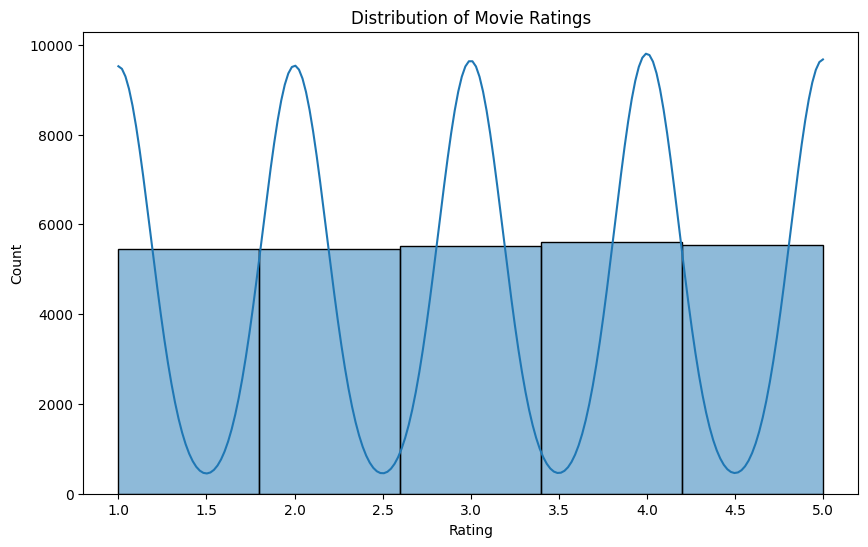

In [41]:
# Visualize the distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_interactions['rating'], bins=5, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

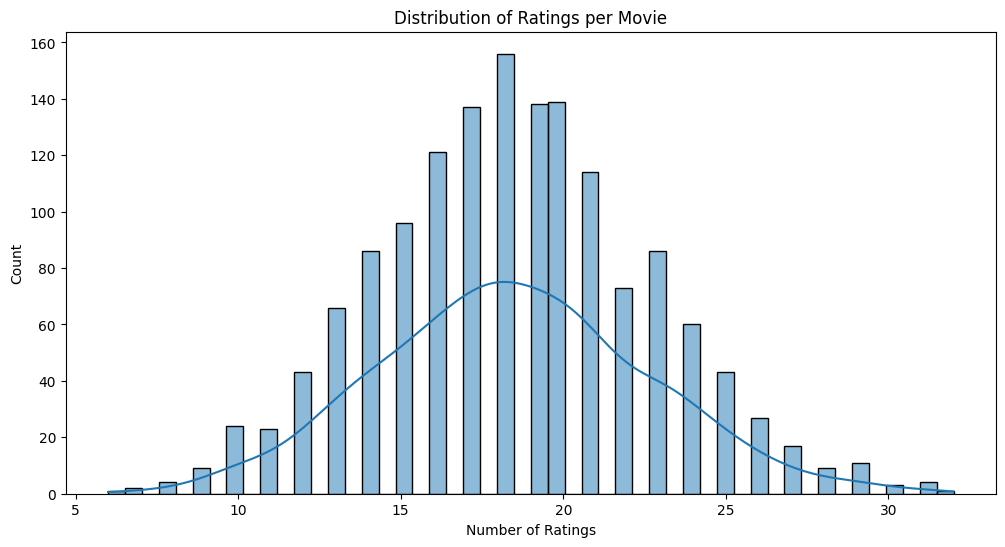

In [42]:
# Visualize the number of ratings per movie
movie_rating_counts = df_interactions['movie_id'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(movie_rating_counts, bins=50, kde=True)
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()


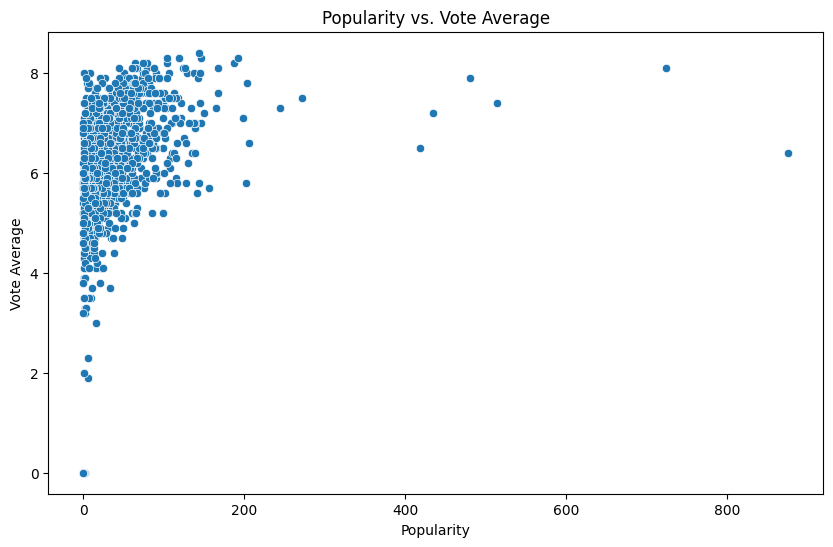

In [43]:
# Analyze correlation between popularity and vote average
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_movies, x='popularity', y='vote_average')
plt.title('Popularity vs. Vote Average')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.show()

In [44]:
# Get top 10 recommendations
user_id = 1  # Example user ID
user_movies = df_interactions[df_interactions['user_id'] == user_id]['movie_id'].tolist()

# Create a DataFrame with all movies not rated by the user
top_movies = df_movies[~df_movies['id'].isin(user_movies)].copy()

# Create a DataFrame in the format expected by the model
pred_df = pd.DataFrame({
    'user_id': [user_id] * len(top_movies),
    'movie_id': top_movies['id']
})

# Get predictions
preds = learn.get_preds(dl=dls.test_dl(pred_df))
top_movies['predicted_rating'] = preds[0].numpy()

# Sort and get top 10 recommendations
top_recommendations = top_movies.sort_values('predicted_rating', ascending=False).head(10)

print(f"Top 10 movie recommendations for user {user_id}:")
print(top_recommendations[['title', 'predicted_rating']])

Top 10 movie recommendations for user 1:
                            title  predicted_rating
882                     Lucky You          3.282040
3462               Daddy Day Camp          3.273345
3401                        Twixt          3.272142
2234           A Dangerous Method          3.263457
2717           Brokeback Mountain          3.247185
3320                      Extract          3.238639
2912                    Star Wars          3.236695
4175  Beasts of the Southern Wild          3.228459
2819                 Act of Valor          3.228248
3018              The Fourth Kind          3.225921
